In [1]:
import pandas as pd
import numpy as np
import os

results_dir = "[2] Analyzer Results"

recording_order = [15, 2, 1, 6, 10, 4]# interpulse intervals


prepulse_intensity = {

    "ASR_control":      120,
    "gap_depth":        30,
    "gap_duration_10":  60,
    "gap_duration_20":  60,
    "gap_duration_4":   60,
    "gap_duration_50":  60,
    "gap_duration_8":   60,
    "offset_ASR":       0,
    "offset_PPI_10":    0,
    "offset_PPI_12":    0,
    "offset_PPI_14":    0,
    "offset_PPI_16":    0,
    "offset_PPI_18":    0,
    "offset_PPI_20":    0,
    "offset_PPI_4":     0,
    "offset_PPI_6":     0,
    "offset_PPI_8":     0,
    "offset_PPI_50":    0,
    "tone_in_noise":    80
}
# ...existing code...

dfs = {}
dfs_fit = {}

files = [file for file in os.listdir(results_dir) if file.endswith(('.xlsx', '.xls'))]

for file in files:
    file_path = os.path.join(results_dir, file)
    key = file.split('.')[0]
    if key.endswith('_FIT'):
        dfs_fit[key] = pd.read_excel(file_path)
    else:
        dfs[key] = pd.read_excel(file_path)

print("Raw dataframes:", list(dfs.keys()))
print("Fit dataframes:", list(dfs_fit.keys()))
print(f"Found {len(dfs)} raw and {len(dfs_fit)} fit dataframes in {results_dir}.")
if len(dfs) != len(dfs_fit):
    print("Warning: Mismatch between raw and fit dataframes!")

experiments = dfs[list(dfs.keys())[1]]['experiment'].unique().tolist()
variables = dfs[list(dfs.keys())[1]].columns[4:].tolist()
parameters = dfs[list(dfs.keys())[1]].columns[:4].tolist()
print(f"\nFound {len(experiments)} experiments, {len(variables)} variables and {len(parameters)} parameters:")
print(" "+', '.join(experiments))
print(" "+', '.join(variables))
print(" "+', '.join(parameters))

Raw dataframes: ['RESULTS', 'RESULTS_MERGED', 'RESULTS_MERGED_DATE', 'RESULTS_MERGED_EXP', 'RESULTS_MT10', 'RESULTS_MTT_MERGED', 'RESULTS_MTT_MERGED_DATE', 'RESULTS_MTT_MERGED_EXP', 'RESULTS_T10', 'RESULTS_TT_MERGED', 'RESULTS_TT_MERGED_DATE', 'RESULTS_TT_MERGED_EXP', 'SegmentOrder']
Fit dataframes: []
Found 13 raw and 0 fit dataframes in [2] Analyzer Results.

Found 18 experiments, 7 variables and 4 parameters:
 ASR_control, gap_depth, tone_in_noise, gap_duration_4, gap_duration_8, gap_duration_10, gap_duration_20, gap_duration_50, offset_PPI_4, offset_PPI_6, offset_PPI_8, offset_PPI_10, offset_PPI_12, offset_PPI_14, offset_PPI_16, offset_PPI_18, offset_PPI_20, offset_PPI_50
 reactionTime, peakValue, PTPA, PTTA, RMS, tau, AUC
 animal, sex, date, experiment


---
Expectations:
- date fluctuations
- no repetition differences
- sex differences in strength metrics
- experiment differences, in particular with increased gap / offset
---

In [2]:
# get S from ASR Control
# get PPS from PPI experiments
# get PPSoffset from offset experiments

#calculate %PPI and %PPIoffset

#split all by date and sex

In [3]:
# --- Collect raw rows for each experiment type ---

raw_ctrl_rows = []
raw_ttn_rows = []
raw_mix_rows = []
raw_gap_rows = []
raw_offset_rows = []

for df in dfs.values():
    if {'experiment', 'peakValue', 'date', 'sex'}.issubset(df.columns):
        # ASR_control
        raw_ctrl_rows.extend(df[df['experiment'] == 'ASR_control'][['experiment', 'date', 'sex', 'peakValue']].to_dict('records'))
        # tone_in_noise
        raw_ttn_rows.extend(df[df['experiment'] == 'tone_in_noise'][['experiment', 'date', 'sex', 'peakValue']].to_dict('records'))
        # selected experiments
        mask = ~df['experiment'].isin({'ASR_control', 'tone_in_noise', 'offset_ASR', 'gap_depth'})
        raw_mix_rows.extend(df[mask][['experiment', 'date', 'sex', 'peakValue']].to_dict('records'))
        # gap_duration
        gap_mask = df['experiment'].str.startswith('gap_duration')
        raw_gap_rows.extend(df[gap_mask][['experiment', 'date', 'sex', 'peakValue']].to_dict('records'))
        # offset_PPI
        offset_mask = df['experiment'].str.startswith('offset_PPI')
        raw_offset_rows.extend(df[offset_mask][['experiment', 'date', 'sex', 'peakValue']].to_dict('records'))

print(f"Raw ASR_control rows: {len(raw_ctrl_rows)}")
print(f"Raw tone_in_noise rows: {len(raw_ttn_rows)}")
print(f"Raw selected experiment rows: {len(raw_mix_rows)}")
print(f"Raw gap_duration rows: {len(raw_gap_rows)}")
print(f"Raw offset_PPI rows: {len(raw_offset_rows)}")

# If you want DataFrames:
raw_ctrl_df = pd.DataFrame(raw_ctrl_rows)
raw_ttn_df = pd.DataFrame(raw_ttn_rows)
raw_mix_df = pd.DataFrame(raw_mix_rows)
raw_gap_df = pd.DataFrame(raw_gap_rows)
raw_offset_df = pd.DataFrame(raw_offset_rows)

# --- Collect raw rows for gap_depth experiments ---

raw_gap_depth_rows = []

for df in dfs.values():
    if {'experiment', 'peakValue', 'date', 'sex'}.issubset(df.columns):
        gap_depth_mask = df['experiment'] == 'gap_depth'
        raw_gap_depth_rows.extend(df[gap_depth_mask][['experiment', 'date', 'sex', 'peakValue']].to_dict('records'))

print(f"Raw gap_depth rows: {len(raw_gap_depth_rows)}")

# If you want a DataFrame:
raw_gap_depth_df = pd.DataFrame(raw_gap_depth_rows)

Raw ASR_control rows: 86
Raw tone_in_noise rows: 90
Raw selected experiment rows: 1314
Raw gap_duration rows: 432
Raw offset_PPI rows: 882
Raw gap_depth rows: 96


In [4]:
# ...existing code...

def calc_raw_percent_ppi(raw_df, ctrl_df, label):
    # Ensure peakValue columns are numeric
    raw_df = raw_df.copy()
    ctrl_df = ctrl_df.copy()
    raw_df['peakValue'] = pd.to_numeric(raw_df['peakValue'], errors='coerce')
    ctrl_df['peakValue'] = pd.to_numeric(ctrl_df['peakValue'], errors='coerce')
    # Merge raw_df with ctrl_df on date and sex to get S for each PPS
    merged = pd.merge(raw_df, ctrl_df, on=['date', 'sex'], suffixes=('', '_ctrl'))
    merged = merged[pd.notna(merged['peakValue_ctrl']) & pd.notna(merged['peakValue']) & (merged['peakValue_ctrl'] != 0)]
    merged['percent_ppi'] = 100 * (merged['peakValue_ctrl'] - merged['peakValue']) / merged['peakValue_ctrl']
    # Group by experiment
    group_means = merged.groupby('experiment')['percent_ppi'].mean()
    # Count negative and positive cases
    neg_count = (merged['percent_ppi'] < 0).sum()
    pos_count = (merged['percent_ppi'] >= 0).sum()
    total_count = len(merged)
    neg_percent = 100 * neg_count / total_count if total_count > 0 else 0
    print(f"\n{label}:")
    print("Average %PPI per experiment:")
    print(group_means)
    print(f"Negative %PPI cases: {neg_count}")
    print(f"Positive %PPI cases: {pos_count}")
    print(f"Percent negative cases: {neg_percent:.2f}%")
    return merged

# Example usage for gap_duration and offset_PPI
# ...existing code...

gap_results = calc_raw_percent_ppi(raw_gap_df, raw_ctrl_df, "gap_duration")
offset_results = calc_raw_percent_ppi(raw_offset_df, raw_ctrl_df, "offset_PPI")
ttn_results = calc_raw_percent_ppi(raw_ttn_df, raw_ctrl_df, "tone_in_noise")
mix_results = calc_raw_percent_ppi(raw_mix_df, raw_ctrl_df, "selected experiments")
gap_depth_results = calc_raw_percent_ppi(raw_gap_depth_df, raw_ctrl_df, "gap_depth")

# ...existing code...


gap_duration:
Average %PPI per experiment:
experiment
gap_duration_10    1.408016
gap_duration_20   -5.139090
gap_duration_4    -8.498277
gap_duration_50   -1.112297
gap_duration_8    -4.844305
Name: percent_ppi, dtype: float64
Negative %PPI cases: 700
Positive %PPI cases: 846
Percent negative cases: 45.28%

offset_PPI:
Average %PPI per experiment:
experiment
offset_PPI_10     8.425408
offset_PPI_12    10.188344
offset_PPI_14     4.393642
offset_PPI_16     8.449032
offset_PPI_18     8.636362
offset_PPI_20     6.568243
offset_PPI_4      3.610103
offset_PPI_50     1.553992
offset_PPI_6      7.469056
offset_PPI_8     11.153053
Name: percent_ppi, dtype: float64
Negative %PPI cases: 1049
Positive %PPI cases: 2115
Percent negative cases: 33.15%

tone_in_noise:
Average %PPI per experiment:
experiment
tone_in_noise    23.646059
Name: percent_ppi, dtype: float64
Negative %PPI cases: 44
Positive %PPI cases: 277
Percent negative cases: 13.71%

selected experiments:
Average %PPI per experiment:
e

In [5]:
# --- ASR_control ---
asr_data_ctrl = []

for df in dfs.values():
    if {'experiment', 'peakValue', 'date', 'sex'}.issubset(df.columns):
        asr_control = df[df['experiment'] == 'ASR_control'].copy()
        asr_control['peakValue'] = pd.to_numeric(asr_control['peakValue'], errors='coerce')
        asr_data_ctrl.append(asr_control[['date', 'sex', 'peakValue']])

ctrl_dict = {}
if asr_data_ctrl:
    asr_df = pd.concat(asr_data_ctrl, ignore_index=True)
    avg_by_date_sex = asr_df.groupby(['date', 'sex'])['peakValue'].mean().reset_index()
    print("Average peakValue from ASR_control experiments split by date and sex:")
    #print(avg_by_date_sex)
    overall_avg = asr_df['peakValue'].mean()
    print(f"Overall average peakValue from ASR_control experiments: {overall_avg:.2f}")
    ctrl_dict = {(row['date'], row['sex']): row['peakValue'] for _, row in avg_by_date_sex.iterrows()}
else:
    print("No ASR_control experiments with date, sex, and peakValue found.")


# --- tone_in_noise ---
asr_ttn = []

for df in dfs.values():
    if {'experiment', 'peakValue', 'date', 'sex'}.issubset(df.columns):
        ttn_control = df[df['experiment'] == 'tone_in_noise'].copy()
        ttn_control['peakValue'] = pd.to_numeric(ttn_control['peakValue'], errors='coerce')
        asr_ttn.append(ttn_control[['date', 'sex', 'peakValue']])

ttn_dict = {}
if asr_ttn:
    ttn_df = pd.concat(asr_ttn, ignore_index=True)
    avg_by_date_sex = ttn_df.groupby(['date', 'sex'])['peakValue'].mean().reset_index()
    print("\nAverage peakValue from tone_in_noise experiments split by date and sex:")
    #print(avg_by_date_sex)
    overall_avg = ttn_df['peakValue'].mean()
    print(f"Overall average peakValue from tone_in_noise experiments: {overall_avg:.2f}")
    ttn_dict = {(row['date'], row['sex']): row['peakValue'] for _, row in avg_by_date_sex.iterrows()}
else:
    print("\nNo tone_in_noise experiments with date, sex, and peakValue found.")


# --- Average peakValue across selected experiments (excluding ASR_control, tone_in_noise, offset_ASR, gap_depth) ---
excluded_experiments = {'ASR_control', 'tone_in_noise', 'offset_ASR', 'gap_depth'}
multi_exp_data = []

for df in dfs.values():
    if {'experiment', 'peakValue', 'date', 'sex'}.issubset(df.columns):
        mask = ~df['experiment'].isin(excluded_experiments)
        selected = df[mask].copy()
        selected['peakValue'] = pd.to_numeric(selected['peakValue'], errors='coerce')
        multi_exp_data.append(selected[['experiment', 'date', 'sex', 'peakValue']])

mix_dict = {}
if multi_exp_data:
    multi_exp_df = pd.concat(multi_exp_data, ignore_index=True)
    avg_by_exp_date_sex = multi_exp_df.groupby(['experiment', 'date', 'sex'])['peakValue'].mean().reset_index()
    print("\nAverage peakValue from selected experiments split by experiment, date, and sex:")
    #print(avg_by_exp_date_sex)
    overall_avg = multi_exp_df['peakValue'].mean()
    print(f"Overall average peakValue from selected experiments: {overall_avg:.2f}")
    mix_dict = {(row['experiment'], row['date'], row['sex']): row['peakValue'] for _, row in avg_by_exp_date_sex.iterrows()}
else:
    print("\nNo selected experiments with date, sex, and peakValue found.")


# --- Average peakValue for gap_duration experiments ---
gap_duration_data = []

for df in dfs.values():
    if {'experiment', 'peakValue', 'date', 'sex'}.issubset(df.columns):
        gap_mask = df['experiment'].str.startswith('gap_duration')
        gap_df = df[gap_mask].copy()
        gap_df['peakValue'] = pd.to_numeric(gap_df['peakValue'], errors='coerce')
        gap_duration_data.append(gap_df[['experiment', 'date', 'sex', 'peakValue']])

gap_dict = {}
if gap_duration_data:
    gap_duration_df = pd.concat(gap_duration_data, ignore_index=True)
    avg_by_gap_date_sex = gap_duration_df.groupby(['experiment', 'date', 'sex'])['peakValue'].mean().reset_index()
    print("\nAverage peakValue from gap_duration experiments split by experiment, date, and sex:")
    #print(avg_by_gap_date_sex)
    overall_avg = gap_duration_df['peakValue'].mean()
    print(f"Overall average peakValue from gap_duration experiments: {overall_avg:.2f}")
    gap_dict = {(row['experiment'], row['date'], row['sex']): row['peakValue'] for _, row in avg_by_gap_date_sex.iterrows()}
else:
    print("\nNo gap_duration experiments with date, sex, and peakValue found.")


# --- Average peakValue for offset_PPI experiments ---
offset_ppi_data = []

for df in dfs.values():
    if {'experiment', 'peakValue', 'date', 'sex'}.issubset(df.columns):
        offset_mask = df['experiment'].str.startswith('offset_PPI')
        offset_df = df[offset_mask].copy()
        offset_df['peakValue'] = pd.to_numeric(offset_df['peakValue'], errors='coerce')
        offset_ppi_data.append(offset_df[['experiment', 'date', 'sex', 'peakValue']])

offset_dict = {}
if offset_ppi_data:
    offset_ppi_df = pd.concat(offset_ppi_data, ignore_index=True)
    avg_by_offset_date_sex = offset_ppi_df.groupby(['experiment', 'date', 'sex'])['peakValue'].mean().reset_index()
    print("\nAverage peakValue from offset_PPI experiments split by experiment, date, and sex:")
    #print(avg_by_offset_date_sex)
    overall_avg = offset_ppi_df['peakValue'].mean()
    print(f"Overall average peakValue from offset_PPI experiments: {overall_avg:.2f}")
    offset_dict = {(row['experiment'], row['date'], row['sex']): row['peakValue'] for _, row in avg_by_offset_date_sex.iterrows()}
else:
    print("\nNo offset_PPI experiments with date, sex, and peakValue found.")



# ...existing code...

# ...existing code...

print()
print("Experiment counts:")
for name in ["ASR_control", "tone_in_noise"]:
    count = sum(df['experiment'].eq(name).sum() if 'experiment' in df.columns else 0 for df in dfs.values())
    print(f"{name}: {count}")
gap_count = sum(df['experiment'].str.startswith('gap_duration').sum() if 'experiment' in df.columns else 0 for df in dfs.values())
print(f"gap_duration: {gap_count}")
offset_count = sum(df['experiment'].str.startswith('offset_PPI').sum() if 'experiment' in df.columns else 0 for df in dfs.values())
print(f"offset_PPI: {offset_count}")
selected_count = sum((~df['experiment'].isin(excluded_experiments)).sum() if 'experiment' in df.columns else 0 for df in dfs.values())
print(f"selected experiments (excluding ASR_control, tone_in_noise, offset_ASR, gap_depth): {selected_count}")

print(ctrl_dict)
print(ttn_dict)
print(mix_dict)
print(gap_dict)
print(offset_dict)
# ...existing code...


Average peakValue from ASR_control experiments split by date and sex:
Overall average peakValue from ASR_control experiments: 60.62

Average peakValue from tone_in_noise experiments split by date and sex:
Overall average peakValue from tone_in_noise experiments: 45.43

Average peakValue from selected experiments split by experiment, date, and sex:
Overall average peakValue from selected experiments: 57.23

Average peakValue from gap_duration experiments split by experiment, date, and sex:
Overall average peakValue from gap_duration experiments: 61.65

Average peakValue from offset_PPI experiments split by experiment, date, and sex:
Overall average peakValue from offset_PPI experiments: 55.07

Experiment counts:
ASR_control: 190
tone_in_noise: 192
gap_duration: 951
offset_PPI: 1916
selected experiments (excluding ASR_control, tone_in_noise, offset_ASR, gap_depth): 2867
{('April16', 'female'): 32.77142857142857, ('April16', 'male'): 60.14523809523809, ('June26', 'female'): 53.4625, ('Jun

In [6]:

print(len(ctrl_dict))
print(len(ttn_dict))
print(len(mix_dict))
print(len(gap_dict))
print(len(offset_dict))

6
6
90
30
60


In [7]:
# --- Average peakValue for gap_depth experiments ---
gap_depth_data = []

for df in dfs.values():
    if {'experiment', 'peakValue', 'date', 'sex'}.issubset(df.columns):
        gap_depth_df = df[df['experiment'] == 'gap_depth'].copy()
        gap_depth_df['peakValue'] = pd.to_numeric(gap_depth_df['peakValue'], errors='coerce')
        gap_depth_data.append(gap_depth_df[['experiment', 'date', 'sex', 'peakValue']])

gap_depth_dict = {}
if gap_depth_data:
    gap_depth_df = pd.concat(gap_depth_data, ignore_index=True)
    avg_by_gap_depth_date_sex = gap_depth_df.groupby(['experiment', 'date', 'sex'])['peakValue'].mean().reset_index()
    print("\nAverage peakValue from gap_depth experiments split by experiment, date, and sex:")
    #print(avg_by_gap_depth_date_sex)
    overall_avg = gap_depth_df['peakValue'].mean()
    print(f"Overall average peakValue from gap_depth experiments: {overall_avg:.2f}")
    gap_depth_dict = {(row['experiment'], row['date'], row['sex']): row['peakValue'] for _, row in avg_by_gap_depth_date_sex.iterrows()}
else:
    print("\nNo gap_depth experiments with date, sex, and peakValue found.")

print(len(gap_depth_dict))
# ...existing code...


Average peakValue from gap_depth experiments split by experiment, date, and sex:
Overall average peakValue from gap_depth experiments: 64.16
6


In [8]:
from scipy.stats import ttest_ind

# --- Calculate overall %PPI for each experiment type ---
def calc_overall_percent_ppi(ctrl_dict, exp_dict, label):
    ppi_values = []
    for key, PPS in exp_dict.items():
        if isinstance(key, tuple) and len(key) == 2:
            date, sex = key
        elif isinstance(key, tuple) and len(key) == 3:
            _, date, sex = key
        else:
            continue
        S = ctrl_dict.get((date, sex), np.nan)
        if pd.notna(S) and pd.notna(PPS) and S != 0:
            ppi = 100 * (S - PPS) / S
            ppi_values.append(ppi)
    print(f"Total experiments for {label}: {len(ppi_values)}")  # <-- Added counter
    if ppi_values:
        overall_ppi = np.nanmean(ppi_values)
        print(f"\nOverall %PPI for {label}: {overall_ppi:.2f}")
    else:
        print(f"\nNo valid %PPI values for {label}.")
    return ppi_values

# Usage for each experiment type
ppi_ttn_vals = calc_overall_percent_ppi(ctrl_dict, ttn_dict, "tone_in_noise")
ppi_mix_vals = calc_overall_percent_ppi(ctrl_dict, mix_dict, "selected experiments")
ppi_gap_vals = calc_overall_percent_ppi(ctrl_dict, gap_dict, "gap_duration")
ppi_offset_vals = calc_overall_percent_ppi(ctrl_dict, offset_dict, "offset_PPI")

# --- Statistical significance between groups ---
print("\nSignificance tests (t-test, unequal variance):")
groups = {
    "tone_in_noise": ppi_ttn_vals,
    "selected experiments": ppi_mix_vals,
    "gap_duration": ppi_gap_vals,
    "offset_PPI": ppi_offset_vals
}

labels = list(groups.keys())
for i in range(len(labels)):
    for j in range(i+1, len(labels)):
        group1 = groups[labels[i]]
        group2 = groups[labels[j]]
        # Only test if both groups have at least 2 values
        if len(group1) > 1 and len(group2) > 1:
            stat, pval = ttest_ind(group1, group2, nan_policy='omit', equal_var=False)
            print(f"{labels[i]} vs {labels[j]}: p = {pval:.4f}")
        else:
            print(f"{labels[i]} vs {labels[j]}: Not enough data for t-test.")

Total experiments for tone_in_noise: 6

Overall %PPI for tone_in_noise: 27.26
Total experiments for selected experiments: 90

Overall %PPI for selected experiments: 8.59
Total experiments for gap_duration: 30

Overall %PPI for gap_duration: 1.93
Total experiments for offset_PPI: 60

Overall %PPI for offset_PPI: 11.92

Significance tests (t-test, unequal variance):
tone_in_noise vs selected experiments: p = 0.0043
tone_in_noise vs gap_duration: p = 0.0006
tone_in_noise vs offset_PPI: p = 0.0102
selected experiments vs gap_duration: p = 0.0021
selected experiments vs offset_PPI: p = 0.0325
gap_duration vs offset_PPI: p = 0.0000


In [9]:
def calc_percent_ppi(ctrl_dict, exp_dict, label):
    # Average %PPI per (experiment, date, sex) or (date, sex)
    percent_ppi = {}
    values_by_group = {}
    for key, PPS in exp_dict.items():
        if isinstance(key, tuple) and len(key) == 2:
            # (date, sex)
            group_key = key
            date, sex = key
        elif isinstance(key, tuple) and len(key) == 3:
            # (experiment, date, sex)
            group_key = key
            _, date, sex = key
        else:
            continue
        S = ctrl_dict.get((date, sex), np.nan)
        if pd.notna(S) and pd.notna(PPS) and S != 0:
            ppi_val = 100 * (S - PPS) / S
        else:
            ppi_val = np.nan
        if group_key not in values_by_group:
            values_by_group[group_key] = []
        values_by_group[group_key].append(ppi_val)
    # Average over all values for each group
    for group_key, vlist in values_by_group.items():
        vlist = [v for v in vlist if pd.notna(v)]
        percent_ppi[group_key] = np.nanmean(vlist) if vlist else np.nan
    print(f"\n%PPI for {label} (averaged per experiment, date, sex):")
    for k, v in percent_ppi.items():
        print(f"{k}: {v:.2f}" if pd.notna(v) else f"{k}: NaN")
    return percent_ppi


ppi_offset = calc_percent_ppi(ctrl_dict, offset_dict, "offset_PPI")
ppi_gap = calc_percent_ppi(ctrl_dict, gap_dict, "gap_duration")
ppi_ttn = calc_percent_ppi(ctrl_dict, ttn_dict, "tone_in_noise")


%PPI for offset_PPI (averaged per experiment, date, sex):
('offset_PPI_10', 'April16', 'female'): 21.39
('offset_PPI_10', 'April16', 'male'): 17.22
('offset_PPI_10', 'June26', 'female'): 15.02
('offset_PPI_10', 'June26', 'male'): 2.72
('offset_PPI_10', 'May20', 'female'): -1.72
('offset_PPI_10', 'May20', 'male'): 24.13
('offset_PPI_12', 'April16', 'female'): 18.57
('offset_PPI_12', 'April16', 'male'): 11.65
('offset_PPI_12', 'June26', 'female'): 16.58
('offset_PPI_12', 'June26', 'male'): 16.28
('offset_PPI_12', 'May20', 'female'): 10.77
('offset_PPI_12', 'May20', 'male'): 14.10
('offset_PPI_14', 'April16', 'female'): 18.83
('offset_PPI_14', 'April16', 'male'): -2.79
('offset_PPI_14', 'June26', 'female'): -1.41
('offset_PPI_14', 'June26', 'male'): 20.18
('offset_PPI_14', 'May20', 'female'): 16.29
('offset_PPI_14', 'May20', 'male'): 7.94
('offset_PPI_16', 'April16', 'female'): 27.17
('offset_PPI_16', 'April16', 'male'): 8.87
('offset_PPI_16', 'June26', 'female'): 21.13
('offset_PPI_16',

In [10]:
ppi_gap_depth = calc_percent_ppi(ctrl_dict, gap_depth_dict, "gap_depth")


%PPI for gap_depth (averaged per experiment, date, sex):
('gap_depth', 'April16', 'female'): 6.44
('gap_depth', 'April16', 'male'): -11.85
('gap_depth', 'June26', 'female'): 12.06
('gap_depth', 'June26', 'male'): -4.48
('gap_depth', 'May20', 'female'): -12.10
('gap_depth', 'May20', 'male'): -1.20


Tone in noise trendline slope: 4.9700
Gap depth trendline slope: 4.2195


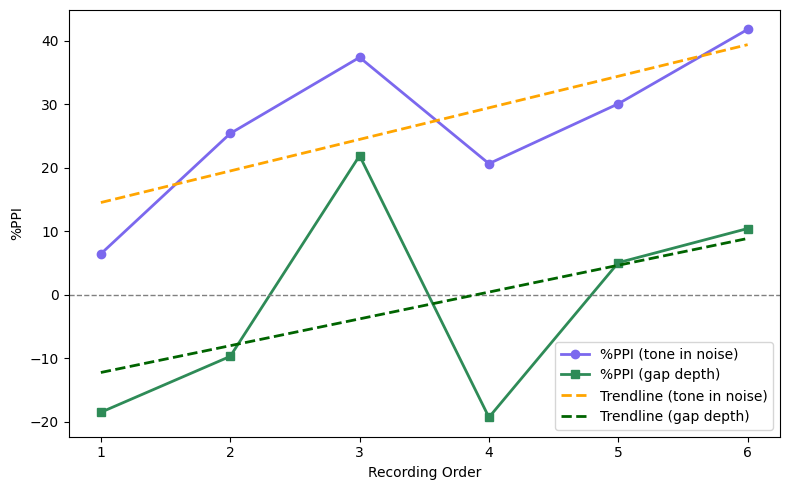

In [11]:
import re
import matplotlib.pyplot as plt
import numpy as np

# Your desired order
recording_order = [15, 2, 1, 6, 10, 4]
animal_order = [f'Animal{num}' for num in recording_order]

def extract_animal_from_any_row(row):
    if 'animal' in row and pd.notna(row['animal']):
        return str(row['animal'])
    if 'experiment' in row and isinstance(row['experiment'], str):
        match = re.search(r'Animal(\d+)', row['experiment'])
        if match:
            return f'Animal{match.group(1)}'
    return None

# --- Tone in noise ---
animal_ppi_ttn = {}
for df in dfs.values():
    if {'experiment', 'date', 'sex', 'peakValue'}.issubset(df.columns):
        ttn_rows = df[df['experiment'] == 'tone_in_noise']
        for _, row in ttn_rows.iterrows():
            date = row['date']
            sex = row['sex']
            PPS = pd.to_numeric(row['peakValue'], errors='coerce')
            S = ctrl_dict.get((date, sex), np.nan)
            animal = extract_animal_from_any_row(row)
            if animal and pd.notna(S) and pd.notna(PPS) and S != 0:
                ppi_val = 100 * (S - PPS) / S
                animal_ppi_ttn.setdefault(animal, []).append(ppi_val)

avg_ppi_per_animal_ttn = {animal: np.nanmean(vals) for animal, vals in animal_ppi_ttn.items() if vals}
sorted_animals = [a for a in animal_order if a in avg_ppi_per_animal_ttn]
sorted_ppi_ttn = [avg_ppi_per_animal_ttn[a] for a in sorted_animals]

# --- Gap depth ---
animal_ppi_gap_depth = {}
for df in dfs.values():
    if {'experiment', 'date', 'sex', 'peakValue'}.issubset(df.columns):
        gap_depth_rows = df[df['experiment'] == 'gap_depth']
        for _, row in gap_depth_rows.iterrows():
            date = row['date']
            sex = row['sex']
            PPS = pd.to_numeric(row['peakValue'], errors='coerce')
            S = ctrl_dict.get((date, sex), np.nan)
            animal = extract_animal_from_any_row(row)
            if animal and pd.notna(S) and pd.notna(PPS) and S != 0:
                ppi_val = 100 * (S - PPS) / S
                animal_ppi_gap_depth.setdefault(animal, []).append(ppi_val)

avg_ppi_per_animal_gap_depth = {animal: np.nanmean(vals) for animal, vals in animal_ppi_gap_depth.items() if vals}
sorted_ppi_gap_depth = [avg_ppi_per_animal_gap_depth[a] for a in sorted_animals]

plt.figure(figsize=(8, 5))
plt.plot(range(1, len(sorted_ppi_ttn)+1), sorted_ppi_ttn, marker='o', color='mediumslateblue', linewidth=2, label='%PPI (tone in noise)')
plt.plot(range(1, len(sorted_ppi_gap_depth)+1), sorted_ppi_gap_depth, marker='s', color='seagreen', linewidth=2, label='%PPI (gap depth)')
plt.ylabel('%PPI')
plt.xlabel('Recording Order')
plt.title('')
plt.xticks(ticks=range(1, 7), labels=[str(i) for i in range(1, 7)])
plt.axhline(0, color='gray', linestyle='--', linewidth=1)

# Add trendlines and print slopes
if len(sorted_ppi_ttn) > 1:
    x = np.arange(1, len(sorted_ppi_ttn)+1)
    z_ttn = np.polyfit(x, sorted_ppi_ttn, 1)
    p_ttn = np.poly1d(z_ttn)
    plt.plot(x, p_ttn(x), color='orange', linestyle='--', linewidth=2, label='Trendline (tone in noise)')
    print(f"Tone in noise trendline slope: {z_ttn[0]:.4f}")

if len(sorted_ppi_gap_depth) > 1:
    x = np.arange(1, len(sorted_ppi_gap_depth)+1)
    z_gap = np.polyfit(x, sorted_ppi_gap_depth, 1)
    p_gap = np.poly1d(z_gap)
    plt.plot(x, p_gap(x), color='darkgreen', linestyle='--', linewidth=2, label='Trendline (gap depth)')
    print(f"Gap depth trendline slope: {z_gap[0]:.4f}")

plt.legend()
plt.tight_layout()
plt.show()

Average trendline slope: 2.5550
Tone in noise trendline slope: 4.9700
Gap depth trendline slope: 4.2195


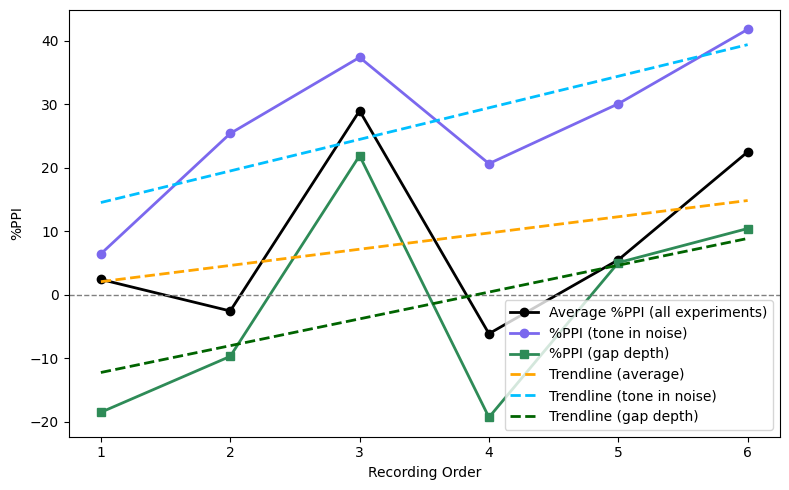

In [12]:
import re
import matplotlib.pyplot as plt
import numpy as np

# Your desired order
recording_order = [15, 2, 1, 6, 10, 4]
animal_order = [f'Animal{num}' for num in recording_order]

def extract_animal_from_any_row(row):
    if 'animal' in row and pd.notna(row['animal']):
        return str(row['animal'])
    if 'experiment' in row and isinstance(row['experiment'], str):
        match = re.search(r'Animal(\d+)', row['experiment'])
        if match:
            return f'Animal{match.group(1)}'
    return None

# --- All experiments ---
animal_ppi_all = {}
for df in dfs.values():
    if {'experiment', 'date', 'sex', 'peakValue'}.issubset(df.columns):
        for _, row in df.iterrows():
            date = row['date']
            sex = row['sex']
            PPS = pd.to_numeric(row['peakValue'], errors='coerce')
            S = ctrl_dict.get((date, sex), np.nan)
            animal = extract_animal_from_any_row(row)
            if animal and pd.notna(S) and pd.notna(PPS) and S != 0:
                ppi_val = 100 * (S - PPS) / S
                animal_ppi_all.setdefault(animal, []).append(ppi_val)

avg_ppi_per_animal = {animal: np.nanmean(vals) for animal, vals in animal_ppi_all.items() if vals}
sorted_animals = [a for a in animal_order if a in avg_ppi_per_animal]
sorted_ppi = [avg_ppi_per_animal[a] for a in sorted_animals]

# --- Tone in noise ---
animal_ppi_ttn = {}
for df in dfs.values():
    if {'experiment', 'date', 'sex', 'peakValue'}.issubset(df.columns):
        ttn_rows = df[df['experiment'] == 'tone_in_noise']
        for _, row in ttn_rows.iterrows():
            date = row['date']
            sex = row['sex']
            PPS = pd.to_numeric(row['peakValue'], errors='coerce')
            S = ctrl_dict.get((date, sex), np.nan)
            animal = extract_animal_from_any_row(row)
            if animal and pd.notna(S) and pd.notna(PPS) and S != 0:
                ppi_val = 100 * (S - PPS) / S
                animal_ppi_ttn.setdefault(animal, []).append(ppi_val)

avg_ppi_per_animal_ttn = {animal: np.nanmean(vals) for animal, vals in animal_ppi_ttn.items() if vals}
sorted_ppi_ttn = [avg_ppi_per_animal_ttn[a] for a in sorted_animals]

# --- Gap depth ---
animal_ppi_gap_depth = {}
for df in dfs.values():
    if {'experiment', 'date', 'sex', 'peakValue'}.issubset(df.columns):
        gap_depth_rows = df[df['experiment'] == 'gap_depth']
        for _, row in gap_depth_rows.iterrows():
            date = row['date']
            sex = row['sex']
            PPS = pd.to_numeric(row['peakValue'], errors='coerce')
            S = ctrl_dict.get((date, sex), np.nan)
            animal = extract_animal_from_any_row(row)
            if animal and pd.notna(S) and pd.notna(PPS) and S != 0:
                ppi_val = 100 * (S - PPS) / S
                animal_ppi_gap_depth.setdefault(animal, []).append(ppi_val)

avg_ppi_per_animal_gap_depth = {animal: np.nanmean(vals) for animal, vals in animal_ppi_gap_depth.items() if vals}
sorted_ppi_gap_depth = [avg_ppi_per_animal_gap_depth[a] for a in sorted_animals]

plt.figure(figsize=(8, 5))
plt.plot(range(1, len(sorted_ppi)+1), sorted_ppi, marker='o', color='black', linewidth=2, label='Average %PPI (all experiments)')
plt.plot(range(1, len(sorted_ppi_ttn)+1), sorted_ppi_ttn, marker='o', color='mediumslateblue', linewidth=2, label='%PPI (tone in noise)')
plt.plot(range(1, len(sorted_ppi_gap_depth)+1), sorted_ppi_gap_depth, marker='s', color='seagreen', linewidth=2, label='%PPI (gap depth)')
plt.ylabel('%PPI')
plt.xlabel('Recording Order')
plt.title('')
plt.xticks(ticks=range(1, len(animal_order)+1), labels=[str(i) for i in range(1, len(animal_order)+1)])
plt.axhline(0, color='gray', linestyle='--', linewidth=1)

# Add trendlines and print slopes
if len(sorted_ppi) > 1:
    x = np.arange(1, len(sorted_ppi)+1)
    z = np.polyfit(x, sorted_ppi, 1)
    p = np.poly1d(z)
    plt.plot(x, p(x), color='orange', linestyle='--', linewidth=2, label='Trendline (average)')
    print(f"Average trendline slope: {z[0]:.4f}")

if len(sorted_ppi_ttn) > 1:
    x = np.arange(1, len(sorted_ppi_ttn)+1)
    z_ttn = np.polyfit(x, sorted_ppi_ttn, 1)
    p_ttn = np.poly1d(z_ttn)
    plt.plot(x, p_ttn(x), color='deepskyblue', linestyle='--', linewidth=2, label='Trendline (tone in noise)')
    print(f"Tone in noise trendline slope: {z_ttn[0]:.4f}")

if len(sorted_ppi_gap_depth) > 1:
    x = np.arange(1, len(sorted_ppi_gap_depth)+1)
    z_gap = np.polyfit(x, sorted_ppi_gap_depth, 1)
    p_gap = np.poly1d(z_gap)
    plt.plot(x, p_gap(x), color='darkgreen', linestyle='--', linewidth=2, label='Trendline (gap depth)')
    print(f"Gap depth trendline slope: {z_gap[0]:.4f}")

plt.legend()
plt.tight_layout()
plt.show()

In [13]:
# --- Test effect of gap_duration/offset_PPI trailing number on %PPI, split by experiment type only ---

from scipy.stats import kruskal
import re

def extract_trailing_number(experiment_name):
    match = re.search(r'(\d+)$', experiment_name)
    return int(match.group(1)) if match else None

# --- Test effect of gap_duration/offset_PPI trailing number on %PPI, split by experiment type only ---

from scipy.stats import ttest_ind
import re

def extract_trailing_number(experiment_name):
    match = re.search(r'(\d+)$', experiment_name)
    return int(match.group(1)) if match else None

def collect_ppi_by_param(exp_dict, ctrl_dict, param_type):
    # Collect raw %PPI values by trailing number for each experiment type (ignoring date/sex)
    grouped = {}
    for key in exp_dict:
        if isinstance(key, tuple) and len(key) == 3:
            experiment, date, sex = key
            if experiment.startswith(param_type):
                num = extract_trailing_number(experiment)
                S = ctrl_dict.get((date, sex), np.nan)
                PPS = exp_dict[key]
                if num is not None and pd.notna(S) and pd.notna(PPS) and S != 0:
                    ppi_val = 100 * (S - PPS) / S
                    grouped.setdefault(num, []).append(ppi_val)
    return grouped

# Collect raw %PPI values by trailing number (all dates/sex pooled)
gap_raw_groups = collect_ppi_by_param(gap_dict, ctrl_dict, 'gap_duration')
offset_raw_groups = collect_ppi_by_param(offset_dict, ctrl_dict, 'offset_PPI')

def test_and_report_parametric(groups, label):
    print(f"\nEffect of {label} (trailing number) on %PPI (all dates/sex pooled):")
    for k in sorted(groups):
        vals = groups[k]
        print(f"{label} {k}: n={len(vals)}, mean={np.mean(vals):.2f}, median={np.median(vals):.2f}")
    valid_keys = [k for k, v in groups.items() if len(v) > 1]
    valid_groups = [groups[k] for k in valid_keys]
    if len(valid_groups) > 1:
        # Pairwise t-tests between all groups
        for i in range(len(valid_groups)):
            for j in range(i+1, len(valid_groups)):
                stat, p = ttest_ind(valid_groups[i], valid_groups[j], equal_var=False, nan_policy='omit')
                print(f"t-test {label} {valid_keys[i]} vs {label} {valid_keys[j]}: t={stat:.2f}, p={p:.4f}")
    else:
        print("Not enough data for t-tests.")

# Run for gap_duration and offset_PPI (pooled by experiment type)
test_and_report_parametric(gap_raw_groups, "gap_duration")
test_and_report_parametric(offset_raw_groups, "offset_PPI")


Effect of gap_duration (trailing number) on %PPI (all dates/sex pooled):
gap_duration 4: n=6, mean=-2.64, median=-3.15
gap_duration 8: n=6, mean=0.91, median=-0.53
gap_duration 10: n=6, mean=5.98, median=6.40
gap_duration 20: n=6, mean=0.57, median=2.39
gap_duration 50: n=6, mean=4.81, median=6.32
t-test gap_duration 10 vs gap_duration 20: t=1.09, p=0.3013
t-test gap_duration 10 vs gap_duration 4: t=1.67, p=0.1282
t-test gap_duration 10 vs gap_duration 50: t=0.29, p=0.7776
t-test gap_duration 10 vs gap_duration 8: t=0.81, p=0.4430
t-test gap_duration 20 vs gap_duration 4: t=0.56, p=0.5881
t-test gap_duration 20 vs gap_duration 50: t=-0.89, p=0.3990
t-test gap_duration 20 vs gap_duration 8: t=-0.05, p=0.9612
t-test gap_duration 4 vs gap_duration 50: t=-1.49, p=0.1717
t-test gap_duration 4 vs gap_duration 8: t=-0.51, p=0.6194
t-test gap_duration 50 vs gap_duration 8: t=0.63, p=0.5453

Effect of offset_PPI (trailing number) on %PPI (all dates/sex pooled):
offset_PPI 4: n=6, mean=9.08, me

In [14]:
def average_ppi_by_sex(ppi_dict, label):
    # Collect values by sex
    
    print(f"\nAverage %PPI across dates for {label}:")
    PPF_count = 0
    PPI_count = 0
    PPF = {}
    values_by_sex = {}
    for key, val in ppi_dict.items():
        if isinstance(key, tuple):
            sex = key[-1]  # works for (date, sex) or (experiment, date, sex)
            if pd.notna(val):
                values_by_sex.setdefault(sex, []).append(val)
                if val < 0:
                    PPF_count += 1
                    PPF[key] = val
                else:
                    PPI_count += 1
    print(f"PPI count: {PPI_count}")
    # Average for each sex
    
    avg_by_sex = {sex: np.nanmean(vals) if vals else np.nan for sex, vals in values_by_sex.items()}
    for sex, avg in avg_by_sex.items():
        print(f"{sex}: {avg:.2f}" if pd.notna(avg) else f"{sex}: NaN")
    print(f"mean: {np.mean(list(avg_by_sex.values())):.2f}")
    print(f"PPF count: {PPF_count}")
    for k, v in PPF.items():
        #print(f"{k}: {v:.2f}")
        pass
    print(f"PPF mean: {np.mean(list(PPF.values())):.2f}" if PPF else "PPF mean: NaN")
    return None

# Example usage:

average_ppi_by_sex(ppi_offset, "offset_PPI")
average_ppi_by_sex(ppi_gap, "gap_duration")
average_ppi_by_sex(ppi_ttn, "tone_in_noise")
average_ppi_by_sex(ppi_gap_depth, "gap_depth")


Average %PPI across dates for offset_PPI:
PPI count: 53
female: 12.31
male: 11.52
mean: 11.92
PPF count: 7
PPF mean: -4.94

Average %PPI across dates for gap_duration:
PPI count: 17
female: 3.25
male: 0.61
mean: 1.93
PPF count: 13
PPF mean: -7.09

Average %PPI across dates for tone_in_noise:
PPI count: 6
female: 29.70
male: 24.82
mean: 27.26
PPF count: 0
PPF mean: NaN

Average %PPI across dates for gap_depth:
PPI count: 2
female: 2.13
male: -5.84
mean: -1.86
PPF count: 4
PPF mean: -7.41


In [15]:
def average_ppi_by_sex(ppi_dict, label):
    # Collect values by sex
    print(f"\nAverage %PPI across dates for {label}:")
    values_by_sex = {}
    PPF = {}
    total_count = 0
    PPF_count = 0
    PPI_count = 0
    for key, val in ppi_dict.items():
        if isinstance(key, tuple):
            sex = key[-1]
            if pd.notna(val):
                values_by_sex.setdefault(sex, []).append(val)
                total_count += 1
                if val < 0:
                    PPF_count += 1
                    PPF[key] = val
                else:
                    PPI_count += 1
    # Print total number of entries in ppi_dict that are not nan
    print(f"Total valid cases: {sum(pd.notna(v) for v in ppi_dict.values())}")
    print(f"Total counted cases: {total_count}")
    print(f"PPI count (>=0): {PPI_count}")
    print(f"PPF count (<0): {PPF_count}")
    avg_by_sex = {sex: np.nanmean(vals) if vals else np.nan for sex, vals in values_by_sex.items()}
    for sex, avg in avg_by_sex.items():
        print(f"{sex}: {avg:.2f}" if pd.notna(avg) else f"{sex}: NaN")
    print(f"mean: {np.mean(list(avg_by_sex.values())):.2f}")
    print(f"PPF mean: {np.mean(list(PPF.values())):.2f}" if PPF else "PPF mean: NaN")
    return None

# Example usage:
average_ppi_by_sex(ppi_offset, "offset_PPI")
average_ppi_by_sex(ppi_gap, "gap_duration")
average_ppi_by_sex(ppi_ttn, "tone_in_noise")
average_ppi_by_sex(ppi_gap_depth, "gap_depth")


Average %PPI across dates for offset_PPI:
Total valid cases: 60
Total counted cases: 60
PPI count (>=0): 53
PPF count (<0): 7
female: 12.31
male: 11.52
mean: 11.92
PPF mean: -4.94

Average %PPI across dates for gap_duration:
Total valid cases: 30
Total counted cases: 30
PPI count (>=0): 17
PPF count (<0): 13
female: 3.25
male: 0.61
mean: 1.93
PPF mean: -7.09

Average %PPI across dates for tone_in_noise:
Total valid cases: 6
Total counted cases: 6
PPI count (>=0): 6
PPF count (<0): 0
female: 29.70
male: 24.82
mean: 27.26
PPF mean: NaN

Average %PPI across dates for gap_depth:
Total valid cases: 6
Total counted cases: 6
PPI count (>=0): 2
PPF count (<0): 4
female: 2.13
male: -5.84
mean: -1.86
PPF mean: -7.41


In [16]:
print("\nTotal number of cases per experiment type:")
print(f"gap_duration: {len(gap_dict)}")
print(f"offset_PPI: {len(offset_dict)}")
print(f"tone_in_noise: {len(ttn_dict)}")
print(f"selected experiments: {len(mix_dict)}")


Total number of cases per experiment type:
gap_duration: 30
offset_PPI: 60
tone_in_noise: 6
selected experiments: 90


In [17]:
print("\nNumber of negative %PPI cases for gap_duration experiments:")
gap_keys = set(gap_dict.keys())
negative_count = 0
total_count = 0

for key in gap_keys:
    experiment, date, sex = key
    PPS = gap_dict.get(key)
    S = ctrl_dict.get((date, sex), np.nan)
    if pd.notna(S) and pd.notna(PPS) and S != 0:
        ppi = 100 * (S - PPS) / S
        total_count += 1
        if ppi < 0:
            negative_count += 1

print(f"Negative %PPI cases: {negative_count} out of {total_count}")


Number of negative %PPI cases for gap_duration experiments:
Negative %PPI cases: 13 out of 30


In [18]:
from collections import Counter

print("\nChecking for trends in negative %PPI cases for gap_duration experiments:")

gap_keys = set(gap_dict.keys())
negative_dates = []
negative_sexes = []

for key in gap_keys:
    experiment, date, sex = key
    PPS = gap_dict.get(key)
    S = ctrl_dict.get((date, sex), np.nan)
    if pd.notna(S) and pd.notna(PPS) and S != 0:
        ppi = 100 * (S - PPS) / S
        if ppi < 0:
            negative_dates.append(date)
            negative_sexes.append(sex)

date_counts = Counter(negative_dates)
sex_counts = Counter(negative_sexes)

print("Negative %PPI by date:", dict(date_counts))
print("Negative %PPI by sex:", dict(sex_counts))


Checking for trends in negative %PPI cases for gap_duration experiments:
Negative %PPI by date: {'April16': 3, 'May20': 7, 'June26': 3}
Negative %PPI by sex: {'male': 7, 'female': 6}


In [19]:
print("\n%PPI for each gap_duration experiment:")
gap_keys = set(gap_dict.keys())

for key in sorted(gap_keys):
    # key is (experiment, date, sex)
    experiment, date, sex = key
    PPS = gap_dict.get(key)
    S = ctrl_dict.get((date, sex), np.nan)
    if pd.notna(S) and pd.notna(PPS) and S != 0:
        ppi = 100 * (S - PPS) / S
        print(f"{key}: %PPI = {ppi:.2f}")
    else:
        print(f"{key}: %PPI = NaN")


%PPI for each gap_duration experiment:
('gap_duration_10', 'April16', 'female'): %PPI = 11.36
('gap_duration_10', 'April16', 'male'): %PPI = 3.23
('gap_duration_10', 'June26', 'female'): %PPI = 9.35
('gap_duration_10', 'June26', 'male'): %PPI = 3.45
('gap_duration_10', 'May20', 'female'): %PPI = -5.95
('gap_duration_10', 'May20', 'male'): %PPI = 14.42
('gap_duration_20', 'April16', 'female'): %PPI = 6.30
('gap_duration_20', 'April16', 'male'): %PPI = -9.50
('gap_duration_20', 'June26', 'female'): %PPI = 8.72
('gap_duration_20', 'June26', 'male'): %PPI = -1.52
('gap_duration_20', 'May20', 'female'): %PPI = -11.62
('gap_duration_20', 'May20', 'male'): %PPI = 11.06
('gap_duration_4', 'April16', 'female'): %PPI = 8.89
('gap_duration_4', 'April16', 'male'): %PPI = -4.30
('gap_duration_4', 'June26', 'female'): %PPI = -1.99
('gap_duration_4', 'June26', 'male'): %PPI = 8.18
('gap_duration_4', 'May20', 'female'): %PPI = -18.09
('gap_duration_4', 'May20', 'male'): %PPI = -8.53
('gap_duration_50


%PPI for offset_PPI (averaged per experiment, date, sex):
('offset_PPI_10', 'April16', 'female'): 21.39
('offset_PPI_10', 'April16', 'male'): 17.22
('offset_PPI_10', 'June26', 'female'): 15.02
('offset_PPI_10', 'June26', 'male'): 2.72
('offset_PPI_10', 'May20', 'female'): -1.72
('offset_PPI_10', 'May20', 'male'): 24.13
('offset_PPI_12', 'April16', 'female'): 18.57
('offset_PPI_12', 'April16', 'male'): 11.65
('offset_PPI_12', 'June26', 'female'): 16.58
('offset_PPI_12', 'June26', 'male'): 16.28
('offset_PPI_12', 'May20', 'female'): 10.77
('offset_PPI_12', 'May20', 'male'): 14.10
('offset_PPI_14', 'April16', 'female'): 18.83
('offset_PPI_14', 'April16', 'male'): -2.79
('offset_PPI_14', 'June26', 'female'): -1.41
('offset_PPI_14', 'June26', 'male'): 20.18
('offset_PPI_14', 'May20', 'female'): 16.29
('offset_PPI_14', 'May20', 'male'): 7.94
('offset_PPI_16', 'April16', 'female'): 27.17
('offset_PPI_16', 'April16', 'male'): 8.87
('offset_PPI_16', 'June26', 'female'): 21.13
('offset_PPI_16',

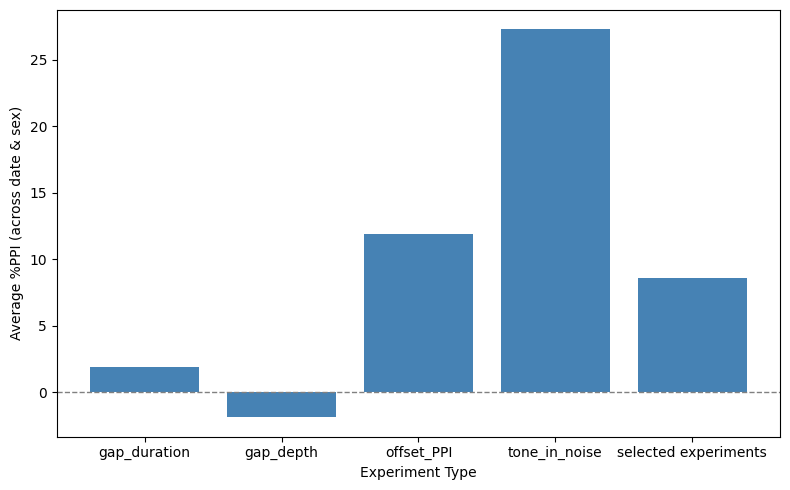

In [20]:
import matplotlib.pyplot as plt
import pandas as pd

# Calculate %PPI for each experiment type (already done above)
ppi_offset = calc_percent_ppi(ctrl_dict, offset_dict, "offset_PPI")
ppi_gap = calc_percent_ppi(ctrl_dict, gap_dict, "gap_duration")
ppi_ttn = calc_percent_ppi(ctrl_dict, ttn_dict, "tone_in_noise")
ppi_mix = calc_percent_ppi(ctrl_dict, mix_dict, "selected experiments")
ppi_gap_depth = calc_percent_ppi(ctrl_dict, gap_depth_dict, "gap_depth")  # <-- add this line

# Average across date and sex for each experiment type
avg_ppi_offset = pd.Series(ppi_offset).mean()
avg_ppi_gap = pd.Series(ppi_gap).mean()
avg_ppi_ttn = pd.Series(ppi_ttn).mean()
avg_ppi_mix = pd.Series(ppi_mix).mean()
avg_ppi_gap_depth = pd.Series(ppi_gap_depth).mean()  # <-- add this line

# Prepare for plotting
labels = ["gap_duration", "gap_depth", "offset_PPI", "tone_in_noise", "selected experiments"]  # <-- add gap_depth
values = [avg_ppi_gap, avg_ppi_gap_depth, avg_ppi_offset, avg_ppi_ttn, avg_ppi_mix]  # <-- add gap_depth

plt.figure(figsize=(8, 5))
plt.bar(labels, values, color="steelblue")
plt.ylabel("Average %PPI (across date & sex)")
plt.xlabel("Experiment Type")
plt.title("")  # No title
plt.axhline(0, color='gray', linestyle='--', linewidth=1)
plt.tight_layout()
plt.show()

C:\Users\Galahad\AppData\Local\Temp\ipykernel_8440\741529974.py:53: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  avg_ppi = all_ppi_df.groupby("experiment")["ppi"].mean().reindex(experiment_order)


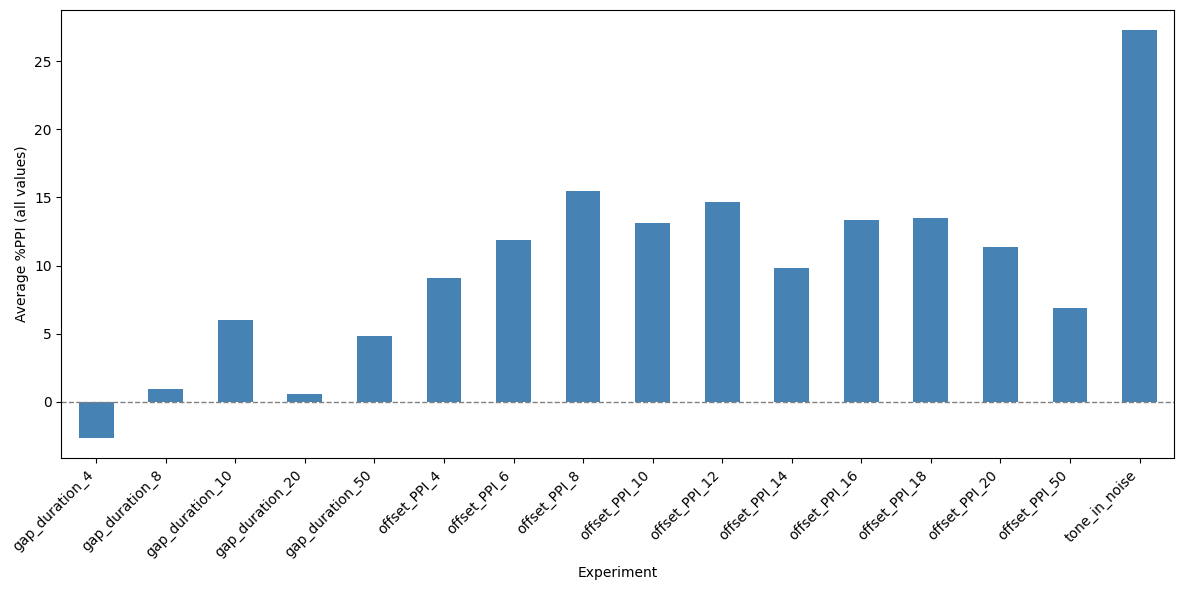

In [21]:
import matplotlib.pyplot as plt
import pandas as pd
import re

# Collect %PPI for all experiments, dates, sexes, including tone_in_noise
ppi_records = []
for d in [gap_dict, offset_dict, ttn_dict, mix_dict]:
    for key in d.keys():
        if isinstance(key, tuple):
            if len(key) == 3:
                experiment, date, sex = key
            elif len(key) == 2:
                experiment = "tone_in_noise" if d is ttn_dict else "unknown"
                date, sex = key
            else:
                continue
        else:
            continue
        PPS = d.get(key)
        S = ctrl_dict.get((date, sex), np.nan)
        if pd.notna(S) and pd.notna(PPS) and S != 0:
            ppi = 100 * (S - PPS) / S
            ppi_records.append({
                "experiment": experiment,
                "date": date,
                "sex": sex,
                "ppi": ppi
            })

# Create DataFrame
all_ppi_df = pd.DataFrame(ppi_records)

# Remove "unknown" experiments
all_ppi_df = all_ppi_df[all_ppi_df["experiment"] != "unknown"]

def experiment_sort_key(exp):
    # Sort gap_duration_X and offset_PPI_X by X (numeric), then tone_in_noise, then others alphabetically
    m_gap = re.match(r"gap_duration_(\d+)", exp)
    m_offset = re.match(r"offset_PPI_(\d+)", exp)
    if m_gap:
        return (0, int(m_gap.group(1)))
    elif m_offset:
        return (1, int(m_offset.group(1)))
    elif exp == "tone_in_noise":
        return (2, 0)
    else:
        return (3, exp)

experiment_order = sorted(all_ppi_df["experiment"].unique(), key=experiment_sort_key)
all_ppi_df["experiment"] = pd.Categorical(all_ppi_df["experiment"], categories=experiment_order, ordered=True)

# Average %PPI per experiment (including tone_in_noise, sorted)
avg_ppi = all_ppi_df.groupby("experiment")["ppi"].mean().reindex(experiment_order)

# Plot (no title)
plt.figure(figsize=(12, 6))
avg_ppi.plot(kind="bar", color="steelblue")
plt.ylabel("Average %PPI (all values)")
plt.xlabel("Experiment")
plt.title("")  # Remove title
plt.axhline(0, color='gray', linestyle='--', linewidth=1)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

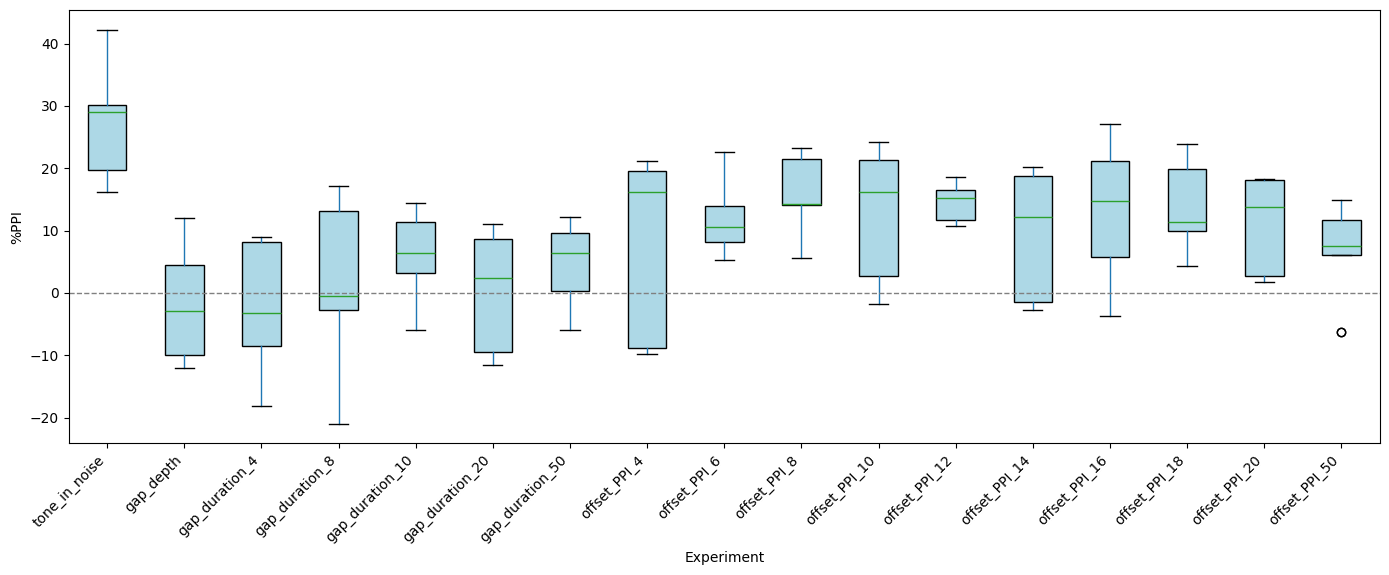

In [22]:
import matplotlib.pyplot as plt
import pandas as pd
import re

# Add gap_depth to the DataFrame for plotting
gap_depth_ppi_records = []
for key, PPS in gap_depth_dict.items():
    if isinstance(key, tuple) and len(key) == 3:
        experiment, date, sex = key
    else:
        continue
    S = ctrl_dict.get((date, sex), np.nan)
    if pd.notna(S) and pd.notna(PPS) and S != 0:
        ppi = 100 * (S - PPS) / S
        gap_depth_ppi_records.append({
            "experiment": "gap_depth",
            "date": date,
            "sex": sex,
            "ppi": ppi
        })

gap_depth_df = pd.DataFrame(gap_depth_ppi_records)
all_ppi_df = pd.concat([all_ppi_df, gap_depth_df], ignore_index=True)

# Remove "unknown" experiments
all_ppi_df = all_ppi_df[all_ppi_df["experiment"] != "unknown"]

def experiment_sort_key(exp):
    # Sort tone_in_noise first, then gap_duration_X, gap_depth, offset_PPI_X by X (numeric), then others alphabetically
    if exp == "tone_in_noise":
        return (0, 0)
    if exp == "gap_depth":
        return (1, 0)
    m_gap = re.match(r"gap_duration_(\d+)", exp)
    m_offset = re.match(r"offset_PPI_(\d+)", exp)
    if m_gap:
        return (2, int(m_gap.group(1)))
    elif m_offset:
        return (3, int(m_offset.group(1)))
    else:
        return (4, exp)

experiment_order = sorted(all_ppi_df["experiment"].unique(), key=experiment_sort_key)
all_ppi_df["experiment"] = pd.Categorical(all_ppi_df["experiment"], categories=experiment_order, ordered=True)

# Boxplot of %PPI per experiment (tone_in_noise, gap_depth, sorted x axis, no title)
plt.figure(figsize=(14, 6))
ax = plt.gca()
all_ppi_df.boxplot(column="ppi", by="experiment", ax=ax, grid=False, patch_artist=True, boxprops=dict(facecolor="lightblue"))
plt.ylabel("%PPI")
plt.xlabel("Experiment")
plt.suptitle("")  # Remove default pandas boxplot title
plt.title("")     # Remove any other title
plt.axhline(0, color='gray', linestyle='--', linewidth=1)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

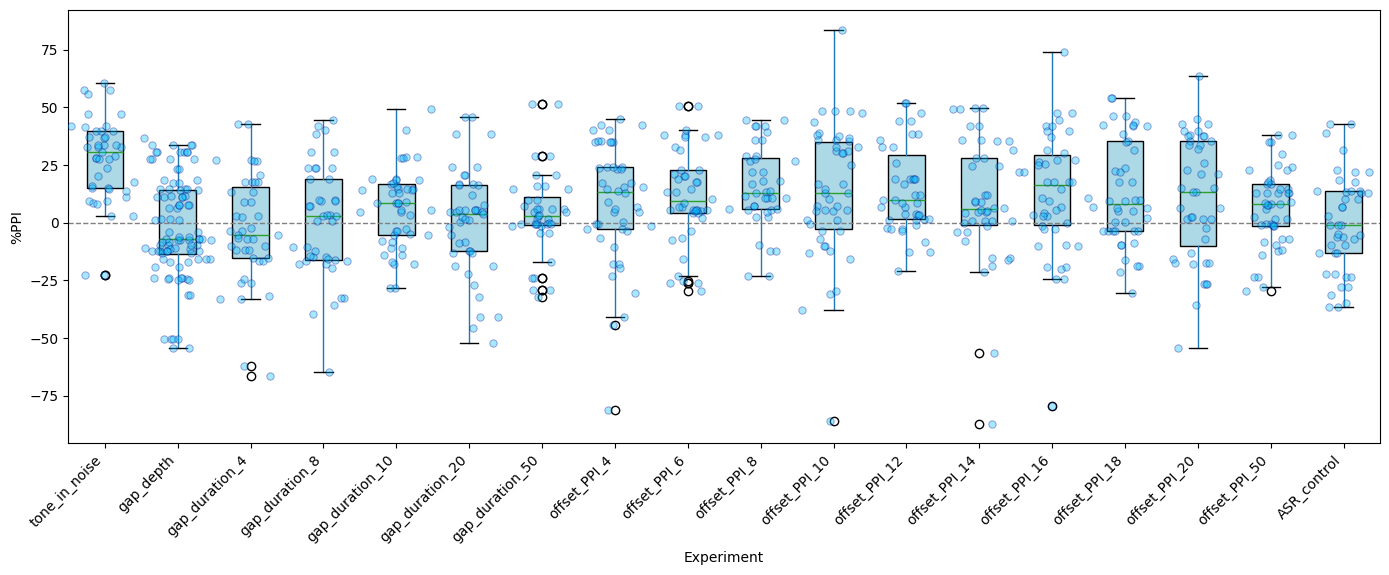

In [37]:
import matplotlib.pyplot as plt
import pandas as pd
import re

# Collect raw %PPI values for all experiments using raw data (not averages)
ppi_records = []
for df in dfs.values():
    if {'experiment', 'peakValue', 'date', 'sex'}.issubset(df.columns):
        for _, row in df.iterrows():
            experiment = row['experiment']
            date = row['date']
            sex = row['sex']
            PPS = pd.to_numeric(row['peakValue'], errors='coerce')
            S = ctrl_dict.get((date, sex), None)
            if pd.notna(S) and pd.notna(PPS) and S != 0:
                ppi = 100 * (S - PPS) / S
                ppi_records.append({
                    "experiment": experiment,
                    "date": date,
                    "sex": sex,
                    "ppi": ppi
                })

# Add gap_depth raw values
for df in dfs.values():
    if {'experiment', 'peakValue', 'date', 'sex'}.issubset(df.columns):
        gap_depth_rows = df[df['experiment'] == 'gap_depth']
        for _, row in gap_depth_rows.iterrows():
            experiment = "gap_depth"
            date = row['date']
            sex = row['sex']
            PPS = pd.to_numeric(row['peakValue'], errors='coerce')
            S = ctrl_dict.get((date, sex), None)
            if pd.notna(S) and pd.notna(PPS) and S != 0:
                ppi = 100 * (S - PPS) / S
                ppi_records.append({
                    "experiment": experiment,
                    "date": date,
                    "sex": sex,
                    "ppi": ppi
                })

all_ppi_df_raw = pd.DataFrame(ppi_records)
all_ppi_df_raw = all_ppi_df_raw[all_ppi_df_raw["experiment"] != "unknown"]

def experiment_sort_key(exp):
    if exp == "tone_in_noise":
        return (0, 0)
    if exp == "gap_depth":
        return (1, 0)
    m_gap = re.match(r"gap_duration_(\d+)", exp)
    m_offset = re.match(r"offset_PPI_(\d+)", exp)
    if m_gap:
        return (2, int(m_gap.group(1)))
    elif m_offset:
        return (3, int(m_offset.group(1)))
    else:
        return (4, exp)

experiment_order = sorted(all_ppi_df_raw["experiment"].unique(), key=experiment_sort_key)
all_ppi_df_raw["experiment"] = pd.Categorical(all_ppi_df_raw["experiment"], categories=experiment_order, ordered=True)

# ...existing code to build all_ppi_df_raw and experiment_order...

plt.figure(figsize=(14, 6))
ax = plt.gca()

# Boxplot
all_ppi_df_raw.boxplot(column="ppi", by="experiment", ax=ax, grid=False, patch_artist=True, boxprops=dict(facecolor="lightblue"))

# Scatterplot overlay with smaller, more transparent dots
for i, exp in enumerate(experiment_order, start=1):
    yvals = all_ppi_df_raw[all_ppi_df_raw["experiment"] == exp]["ppi"]
    xvals = i + 0.18 * (np.random.randn(len(yvals)))
    ax.scatter(
        xvals, yvals,
        color="deepskyblue",
        edgecolor="navy",
        alpha=0.35,      # More see-through
        s=28,            # Smaller dots
        linewidth=0.7,
        marker='o',
        zorder=10
    )

plt.ylabel("%PPI")
plt.xlabel("Experiment")
plt.suptitle("")  # Remove default pandas boxplot title
plt.title("")     # Remove any other title
plt.axhline(0, color='gray', linestyle='--', linewidth=1)
plt.xticks(ticks=range(1, len(experiment_order)+1), labels=experiment_order, rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [23]:
import scipy.stats as stats

# Group %PPI values by experiment
ppi_groups = [group["ppi"].dropna().values for _, group in all_ppi_df.groupby("experiment") if len(group) > 1]

# Only run test if there are at least 2 groups with >1 value
if len(ppi_groups) > 1:
    stat, pval = stats.kruskal(*ppi_groups)
    print(f"Kruskal-Wallis H-test for effect of experiment on %PPI: p = {pval:.4f}")
    if pval < 0.05:
        print("Significant overall effect of experiment on %PPI.")
    else:
        print("No significant overall effect of experiment on %PPI.")
else:
    print("Not enough data for Kruskal-Wallis test.")

Kruskal-Wallis H-test for effect of experiment on %PPI: p = 0.0000
Significant overall effect of experiment on %PPI.


C:\Users\Galahad\AppData\Local\Temp\ipykernel_8440\2551100096.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  ppi_groups = [group["ppi"].dropna().values for _, group in all_ppi_df.groupby("experiment") if len(group) > 1]


In [24]:
from scipy.stats import ttest_ind
import numpy as np
import re

def extract_trailing_number(experiment_name):
    match = re.search(r'(\d+)$', experiment_name)
    return int(match.group(1)) if match else None

def collect_ppi_by_param(exp_dict, ctrl_dict, param_type):
    grouped = {}
    for key in exp_dict:
        if isinstance(key, tuple) and len(key) == 3:
            experiment, date, sex = key
            if experiment.startswith(param_type):
                num = extract_trailing_number(experiment)
                S = ctrl_dict.get((date, sex), np.nan)
                PPS = exp_dict[key]
                if num is not None and pd.notna(S) and pd.notna(PPS) and S != 0:
                    ppi_val = 100 * (S - PPS) / S
                    grouped.setdefault(num, []).append(ppi_val)
    return grouped

# Collect raw %PPI values by trailing number (all dates/sex pooled)
gap_raw_groups = collect_ppi_by_param(gap_dict, ctrl_dict, 'gap_duration')
offset_raw_groups = collect_ppi_by_param(offset_dict, ctrl_dict, 'offset_PPI')

def test_and_report_ttest(groups, label):
    print(f"\nEffect of {label} (trailing number) on %PPI (all dates/sex pooled):")
    sorted_keys = sorted(groups)
    for k in sorted_keys:
        vals = groups[k]
        print(f"{label} {k}: n={len(vals)}, mean={np.mean(vals):.2f}, median={np.median(vals):.2f}")
    valid_keys = [k for k, v in groups.items() if len(v) > 1]
    valid_groups = [groups[k] for k in valid_keys]
    if len(valid_groups) > 1:
        # Pairwise t-tests between all valid groups
        for i in range(len(valid_groups)):
            for j in range(i+1, len(valid_groups)):
                stat, p = ttest_ind(valid_groups[i], valid_groups[j], equal_var=False, nan_policy='omit')
                print(f"t-test {label} {valid_keys[i]} vs {label} {valid_keys[j]}: t={stat:.2f}, p={p:.4f}")
    else:
        print("Not enough data for t-tests.")

# Run for gap_duration and offset_PPI (pooled by experiment type)
test_and_report_ttest(gap_raw_groups, "gap_duration")
test_and_report_ttest(offset_raw_groups, "offset_PPI")


Effect of gap_duration (trailing number) on %PPI (all dates/sex pooled):
gap_duration 4: n=6, mean=-2.64, median=-3.15
gap_duration 8: n=6, mean=0.91, median=-0.53
gap_duration 10: n=6, mean=5.98, median=6.40
gap_duration 20: n=6, mean=0.57, median=2.39
gap_duration 50: n=6, mean=4.81, median=6.32
t-test gap_duration 10 vs gap_duration 20: t=1.09, p=0.3013
t-test gap_duration 10 vs gap_duration 4: t=1.67, p=0.1282
t-test gap_duration 10 vs gap_duration 50: t=0.29, p=0.7776
t-test gap_duration 10 vs gap_duration 8: t=0.81, p=0.4430
t-test gap_duration 20 vs gap_duration 4: t=0.56, p=0.5881
t-test gap_duration 20 vs gap_duration 50: t=-0.89, p=0.3990
t-test gap_duration 20 vs gap_duration 8: t=-0.05, p=0.9612
t-test gap_duration 4 vs gap_duration 50: t=-1.49, p=0.1717
t-test gap_duration 4 vs gap_duration 8: t=-0.51, p=0.6194
t-test gap_duration 50 vs gap_duration 8: t=0.63, p=0.5453

Effect of offset_PPI (trailing number) on %PPI (all dates/sex pooled):
offset_PPI 4: n=6, mean=9.08, me

In [25]:
def calc_percent_ppi(ctrl_dict, exp_dict, label):
    # If exp_dict keys include experiment, average over experiments for each (date, sex)
    percent_ppi = {}
    # Collect values by (date, sex)
    values_by_date_sex = {}
    for key, PPS in exp_dict.items():
        if isinstance(key, tuple) and len(key) == 2:
            date, sex = key
        elif isinstance(key, tuple) and len(key) == 3:
            _, date, sex = key
        else:
            continue
        S = ctrl_dict.get((date, sex), np.nan)
        if pd.notna(S) and pd.notna(PPS) and S != 0:
            ppi_val = 100 * (S - PPS) / S
        else:
            ppi_val = np.nan
        # Group by (date, sex)
        if (date, sex) not in values_by_date_sex:
            values_by_date_sex[(date, sex)] = []
        values_by_date_sex[(date, sex)].append(ppi_val)
    # Average over experiments for each (date, sex)
    for k, vlist in values_by_date_sex.items():
        vlist = [v for v in vlist if pd.notna(v)]
        percent_ppi[k] = np.nanmean(vlist) if vlist else np.nan
    print(f"\n%PPI for {label} (averaged over experiments if multiple):")
    for k, v in percent_ppi.items():
        print(f"{k}: {v:.2f}" if pd.notna(v) else f"{k}: NaN")
    return percent_ppi

# Calculate %PPI for each experiment type
ppi_ttn = calc_percent_ppi(ctrl_dict, ttn_dict, "tone_in_noise")
ppi_mix = calc_percent_ppi(ctrl_dict, mix_dict, "selected experiments")
ppi_gap = calc_percent_ppi(ctrl_dict, gap_dict, "gap_duration")
ppi_offset = calc_percent_ppi(ctrl_dict, offset_dict, "offset_PPI")


%PPI for tone_in_noise (averaged over experiments if multiple):
('April16', 'female'): 29.87
('April16', 'male'): 16.17
('June26', 'female'): 42.23
('June26', 'male'): 30.24
('May20', 'female'): 17.00
('May20', 'male'): 28.06

%PPI for selected experiments (averaged over experiments if multiple):
('April16', 'female'): 16.56
('April16', 'male'): 6.16
('June26', 'female'): 12.05
('June26', 'male'): 6.30
('May20', 'female'): -0.74
('May20', 'male'): 11.19

%PPI for gap_duration (averaged over experiments if multiple):
('April16', 'female'): 11.17
('April16', 'male'): -5.37
('June26', 'female'): 7.43
('June26', 'male'): 3.85
('May20', 'female'): -8.86
('May20', 'male'): 3.34

%PPI for offset_PPI (averaged over experiments if multiple):
('April16', 'female'): 19.26
('April16', 'male'): 11.92
('June26', 'female'): 14.35
('June26', 'male'): 7.53
('May20', 'female'): 3.32
('May20', 'male'): 15.12


In [26]:
def count_negative_ppi(ppi_dict, label):
    negatives = [v for v in ppi_dict.values() if pd.notna(v) and v < 0]
    print(f"\nNumber of negative %PPI cases for {label}: {len(negatives)}")
    return len(negatives)

# Count negative %PPI cases for each
count_negative_ppi(ppi_ttn, "tone_in_noise")
#count_negative_ppi(ppi_mix, "selected experiments")
count_negative_ppi(ppi_gap, "gap_duration")
count_negative_ppi(ppi_offset, "offset_PPI")


Number of negative %PPI cases for tone_in_noise: 0

Number of negative %PPI cases for gap_duration: 2

Number of negative %PPI cases for offset_PPI: 0


0

In [27]:
print("\nDifferences between %PPI groups per (date, sex):")
group_dicts = [ppi_ttn, ppi_gap, ppi_offset]
group_labels = ["tone_in_noise", "gap_duration", "offset_PPI"]

# Get all unique (date, sex) pairs present in any group
all_keys = set()
for d in group_dicts:
    all_keys.update(d.keys())

for key in sorted(all_keys):
    vals = []
    for d in group_dicts:
        v = d.get(key)
        vals.append(v if pd.notna(v) else None)
    # Only compare if at least two groups have values for this (date, sex)
    for i in range(len(vals)):
        for j in range(i+1, len(vals)):
            v1 = vals[i]
            v2 = vals[j]
            if v1 is not None and v2 is not None:
                # t-test not meaningful for single values, so just compare directly
                # If you have replicates per group, you can use arrays and t-test
                # Here, just check difference and print p-value as NA
                if v1 != v2:
                    mean_diff = v1 - v2
                    print(f"{key}: {group_labels[i]} ({v1:.2f}) vs {group_labels[j]} ({v2:.2f}) | Mean diff: {mean_diff:.2f}")


Differences between %PPI groups per (date, sex):
('April16', 'female'): tone_in_noise (29.87) vs gap_duration (11.17) | Mean diff: 18.71
('April16', 'female'): tone_in_noise (29.87) vs offset_PPI (19.26) | Mean diff: 10.62
('April16', 'female'): gap_duration (11.17) vs offset_PPI (19.26) | Mean diff: -8.09
('April16', 'male'): tone_in_noise (16.17) vs gap_duration (-5.37) | Mean diff: 21.54
('April16', 'male'): tone_in_noise (16.17) vs offset_PPI (11.92) | Mean diff: 4.25
('April16', 'male'): gap_duration (-5.37) vs offset_PPI (11.92) | Mean diff: -17.30
('June26', 'female'): tone_in_noise (42.23) vs gap_duration (7.43) | Mean diff: 34.80
('June26', 'female'): tone_in_noise (42.23) vs offset_PPI (14.35) | Mean diff: 27.88
('June26', 'female'): gap_duration (7.43) vs offset_PPI (14.35) | Mean diff: -6.93
('June26', 'male'): tone_in_noise (30.24) vs gap_duration (3.85) | Mean diff: 26.39
('June26', 'male'): tone_in_noise (30.24) vs offset_PPI (7.53) | Mean diff: 22.70
('June26', 'male')

In [28]:
# Collect all negative %PPI values (%PPF) per experiment from the calculated dictionaries

# Assume ppi_gap, ppi_offset, ppi_ttn, ppi_mix are available from previous analysis
# Each is a dictionary: keys are (experiment, date, sex) or (date, sex), values are %PPI

ppf_records = []

def collect_ppf(ppi_dict, label):
    for key, val in ppi_dict.items():
        if pd.notna(val) and val < 0:
            if isinstance(key, tuple):
                if len(key) == 3:
                    experiment, date, sex = key
                elif len(key) == 2:
                    experiment = label
                    date, sex = key
                else:
                    experiment = label
                    date, sex = None, None
            else:
                experiment = label
                date, sex = None, None
            ppf_records.append({
                "experiment": experiment,
                "date": date,
                "sex": sex,
                "ppf_value": val,
                "group": label
            })

collect_ppf(ppi_gap, "gap_duration")
collect_ppf(ppi_offset, "offset_PPI")
collect_ppf(ppi_ttn, "tone_in_noise")
collect_ppf(ppi_mix, "selected_experiments")

import pandas as pd
ppf_df = pd.DataFrame(ppf_records)
print("Extracted %PPF values per experiment:")
print(ppf_df)

Extracted %PPF values per experiment:
             experiment     date     sex  ppf_value                 group
0          gap_duration  April16    male  -5.371917          gap_duration
1          gap_duration    May20  female  -8.860316          gap_duration
2  selected_experiments    May20  female  -0.738730  selected_experiments


In [29]:
import numpy as np
from scipy.stats import ttest_ind

# Collect %PPI for offset_PPI 4,6,8,10 and 12,14,16,18,20,50
low_nums = [4, 6, 8, 12, 14]
high_nums = [16, 18, 20, 50]

def extract_trailing_number(experiment_name):
    import re
    match = re.search(r'(\d+)$', experiment_name)
    return int(match.group(1)) if match else None

low_ppi = []
high_ppi = []

for key, PPS in offset_dict.items():
    if isinstance(key, tuple) and len(key) == 3:
        experiment, date, sex = key
        num = extract_trailing_number(experiment)
        S = ctrl_dict.get((date, sex), np.nan)
        if num in low_nums and pd.notna(S) and pd.notna(PPS) and S != 0:
            ppi_val = 100 * (S - PPS) / S
            low_ppi.append(ppi_val)
        elif num in high_nums and pd.notna(S) and pd.notna(PPS) and S != 0:
            ppi_val = 100 * (S - PPS) / S
            high_ppi.append(ppi_val)

print(f"offset_PPI low group (4,6,8,10): n={len(low_ppi)}, mean={np.mean(low_ppi):.2f}")
print(f"offset_PPI high group (12,14,16,18,20,50): n={len(high_ppi)}, mean={np.mean(high_ppi):.2f}")

if len(low_ppi) > 1 and len(high_ppi) > 1:
    stat, pval = ttest_ind(low_ppi, high_ppi, equal_var=False, nan_policy='omit')
    print(f"t-test: p = {pval:.4f}")
    if pval < 0.05:
        print("Significant difference: lower %PPI for 4,6,8,10 than 12,14,16,18,20,50")
    else:
        print("No significant difference between groups.")
else:
    print("Not enough data for t-test.")

offset_PPI low group (4,6,8,10): n=30, mean=12.19
offset_PPI high group (12,14,16,18,20,50): n=24, mean=11.28
t-test: p = 0.6998
No significant difference between groups.


In [30]:
import numpy as np
from scipy.stats import f_oneway, ttest_ind
import re

def extract_trailing_number(experiment_name):
    match = re.search(r'(\d+)$', experiment_name)
    return int(match.group(1)) if match else None

# Group %PPI values by gap_duration number
gap_groups = {}
for key, PPS in gap_dict.items():
    if isinstance(key, tuple) and len(key) == 3:
        experiment, date, sex = key
        if experiment.startswith('gap_duration'):
            num = extract_trailing_number(experiment)
            S = ctrl_dict.get((date, sex), np.nan)
            if num is not None and pd.notna(S) and pd.notna(PPS) and S != 0:
                ppi_val = 100 * (S - PPS) / S
                gap_groups.setdefault(num, []).append(ppi_val)

# Print group stats
for num in sorted(gap_groups):
    vals = gap_groups[num]
    print(f"gap_duration {num}: n={len(vals)}, mean={np.mean(vals):.2f}, median={np.median(vals):.2f}")

valid_groups = [vals for vals in gap_groups.values() if len(vals) > 1]
if len(valid_groups) > 2:
    stat, pval = f_oneway(*valid_groups)
    print(f"ANOVA for gap_duration effect on %PPI: p = {pval:.4f}")
    if pval < 0.05:
        print("Significant effect of gap duration on %PPI (parametric ANOVA).")
    else:
        print("No significant effect of gap duration on %PPI (parametric ANOVA).")
elif len(valid_groups) == 2:
    stat, pval = ttest_ind(valid_groups[0], valid_groups[1], equal_var=False, nan_policy='omit')
    print(f"t-test for gap_duration effect on %PPI: p = {pval:.4f}")
    if pval < 0.05:
        print("Significant difference between gap durations (parametric t-test).")
    else:
        print("No significant difference between gap durations (parametric t-test).")
else:
    print("Not enough data for parametric test.")

gap_duration 4: n=6, mean=-2.64, median=-3.15
gap_duration 8: n=6, mean=0.91, median=-0.53
gap_duration 10: n=6, mean=5.98, median=6.40
gap_duration 20: n=6, mean=0.57, median=2.39
gap_duration 50: n=6, mean=4.81, median=6.32
ANOVA for gap_duration effect on %PPI: p = 0.5609
No significant effect of gap duration on %PPI (parametric ANOVA).
